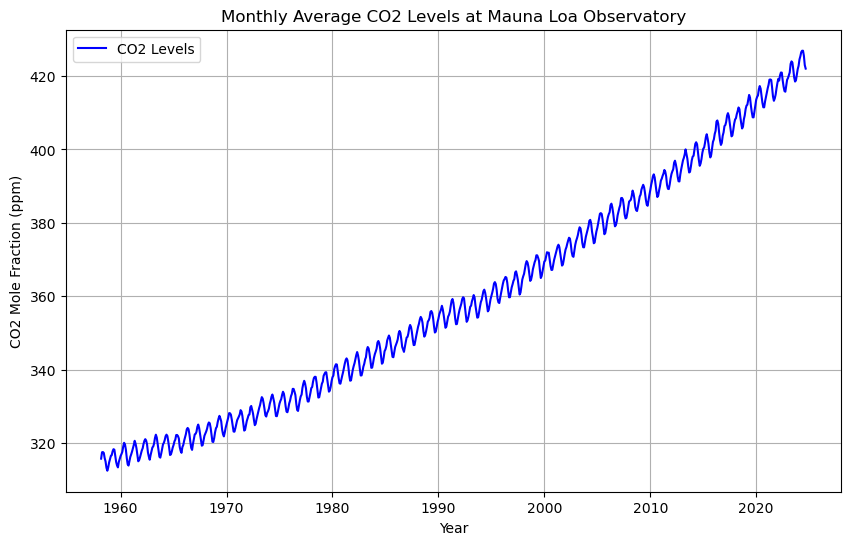

Results of Dickey-Fuller Test:
Test Statistic                   6.250436
p-value                          1.000000
# Lags Used                     21.000000
Number of Observations Used    777.000000
Critical Value (1%)             -3.438794
Critical Value (5%)             -2.865267
Critical Value (10%)            -2.568755
dtype: float64


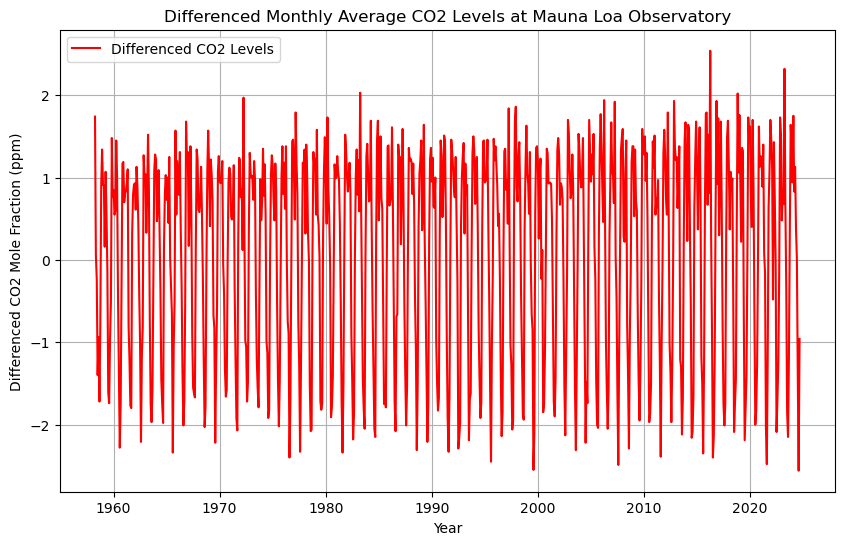

Results of Dickey-Fuller Test on Differenced Series:
Test Statistic                  -5.328293
p-value                          0.000005
# Lags Used                     21.000000
Number of Observations Used    776.000000
Critical Value (1%)             -3.438805
Critical Value (5%)             -2.865272
Critical Value (10%)            -2.568757
dtype: float64


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

file_path = r"C:\Users\gesua\Documents\Capstone_Project\Capstone\co2_mm_mlo.csv"
co2_data = pd.read_csv(file_path)

co2_data.rename(columns={'year': 'year', 'decimal date': 'decimal_date', 'Monthly Average of CO2': 'CO2'}, inplace=True)

co2_data['year'] = co2_data['decimal_date'].astype(int)
co2_data['month'] = ((co2_data['decimal_date'] - co2_data['year']) * 12 + 1).astype(int)

co2_data['date'] = pd.to_datetime(co2_data[['year', 'month']].assign(day=1))
co2_data.set_index('date', inplace=True)

co2_data = co2_data.dropna(subset=['CO2'])

plt.figure(figsize=(10, 6))
plt.plot(co2_data.index, co2_data['CO2'], label='CO2 Levels', color='blue')
plt.title('Monthly Average CO2 Levels at Mauna Loa Observatory')
plt.xlabel('Year')
plt.ylabel('CO2 Mole Fraction (ppm)')
plt.legend()
plt.grid()
plt.show()

print('Results of Dickey-Fuller Test:')
dftest = adfuller(co2_data['CO2'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

if dfoutput['p-value'] > 0.05:
    co2_data_diff = co2_data['CO2'].diff().dropna()

    plt.figure(figsize=(10, 6))
    plt.plot(co2_data_diff, label='Differenced CO2 Levels', color='red')
    plt.title('Differenced Monthly Average CO2 Levels at Mauna Loa Observatory')
    plt.xlabel('Year')
    plt.ylabel('Differenced CO2 Mole Fraction (ppm)')
    plt.legend()
    plt.grid()
    plt.show()

    print('Results of Dickey-Fuller Test on Differenced Series:')
    dftest_diff = adfuller(co2_data_diff)
    dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
    for key, value in dftest_diff[4].items():
        dfoutput_diff[f'Critical Value ({key})'] = value
    print(dfoutput_diff)


In [6]:
#Based on the PACF and ACF, I have determined either (p,d,q) to be (3,1,1) or (3,1,2)
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(co2_data_diff, order=(3, 1, 1))
model_2 = ARIMA(co2_data_diff, order=(3, 1, 2))
fit_1 = model_1.fit()
fit_2 = model_2.fit()

# Print AIC for comparison
print("ARIMA(3, 1, 1) AIC:", fit_1.aic)
print("ARIMA(3, 1, 2) AIC:", fit_2.aic)
if fit_1.aic < fit_2.aic:
    print("ARIMA(3, 1, 1) is the model.")
else:
    print("ARIMA(3, 1, 2) is the model.")


C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(3, 1, 1) AIC: 1790.1342421784236
ARIMA(3, 1, 2) AIC: 1564.0966359184863
ARIMA(3, 1, 2) is the preferred model.


In [20]:
print(co2_data.columns)

Index(['year', 'date_month', 'decimal_date', 'CO2', 'deseasonalized', 'ndays',
       'sdev', 'unc', 'month'],
      dtype='object')


2024-10-01    421.893479
2024-11-01    422.617648
2024-12-01    423.926106
2025-01-01    425.406507
2025-02-01    426.651121
2025-03-01    427.379429
2025-04-01    427.505325
2025-05-01    427.136405
2025-06-01    426.514867
2025-07-01    425.925901
2025-08-01    425.605680
2025-09-01    425.676794
Freq: MS, Name: predicted_mean, dtype: float64


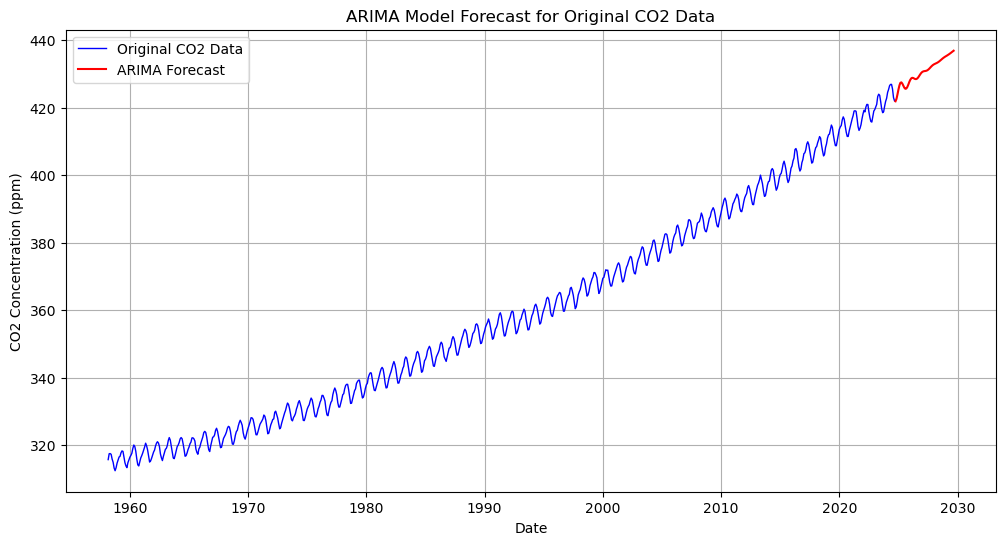

In [32]:
#Graphing the ARIMA Forecast into 2025
print(forecast_original_scale)

forecast_steps = 60
forecast_diff = fit.forecast(steps=forecast_steps)

last_observed_value = co2_data['CO2'].iloc[-1]
forecast_original_scale = forecast_diff.cumsum() + last_observed_value

forecast_dates = pd.date_range(start=co2_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

forecast_df = pd.DataFrame({'Forecast': forecast_original_scale}, index=forecast_dates)

plt.figure(figsize=(12, 6))

plt.plot(co2_data.index, co2_data['CO2'], color='blue', label='Original CO2 Data', linewidth=1)
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', linestyle='-', label='ARIMA Forecast', linewidth=1.5)

plt.title('ARIMA Model Forecast for Original CO2 Data')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


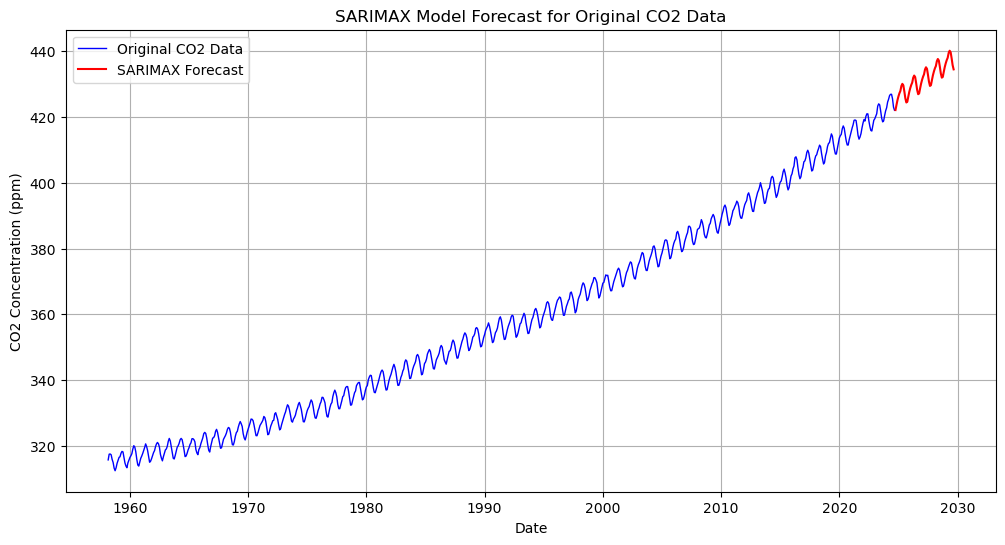

In [44]:
#Showing SARIMA Results
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model
sarimax_order = (3, 1, 2)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
model = SARIMAX(co2_data['CO2'], order=sarimax_order, seasonal_order=seasonal_order)
fit = model.fit(disp=False)

# Forecasting
forecast_steps = 60
forecast = fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=co2_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data['CO2'], color='blue', label='Original CO2 Data', linewidth=1)
plt.plot(forecast_series.index, forecast_series, color='red', linestyle='-', label='SARIMAX Forecast', linewidth=1.5)
plt.title('SARIMAX Model Forecast for Original CO2 Data')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.show()